# Traffic Signals Detection Model Preparation

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import math
import pandas as pd
import pickle
import time
from tqdm.notebook import tnrange
from IPython.display import clear_output
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [2]:
fileName = 'Model_Conv_2.0.h5'

In [3]:
def callback(obj,fileName) :
    print('CallBack : ',fileName,'Updated')
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)

### Activations

In [4]:
class ReLU :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'ReLU'
    
    def feed(self,X) :
        outputs = []
        for x in X :
            output = np.maximum(0,x)
            outputs.append(output)
        return outputs
    
    def feed_back(self,Z,grad_output,lr) :
        grad = Z
        grad[Z < 0] = 0
        return grad_output*grad
    
    def predict(self,Y) :
        output = np.maximum(0,Y)
        return output
    
class TanH :
    def __init__(self) :
        self.__type__ = 'activation'
        self.__Name__ = 'TanH'
    def feed(self,X) :
        outputs = []
        for x in X :
            output = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
            outputs.append(output)
        return outputs
        
    def feed_back(self,Z,grad_output,lr) :
        return 1-np.power(self.output,2)
    
    def predict(self,Y) :
        output = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return output
        
class Softmax :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Softmax'
    
    def feed(self,X) :
        outputs = []
        for x in X :
            e_x = np.exp(x - np.max(x))
            output = e_x/np.sum(e_x)
            outputs.append(output)
        return outputs
    
    def grad_feed(self,X) :
        e_x = np.exp(X - np.max(X))
        out = (e_x/e_x.sum()) - ((e_x*e_x)/np.power(e_x.sum(),2))
        return out
    
    def feed_back(self,Z,grad_output,lr) :
        e_x = np.exp(Z - np.max(Z))
        out = e_x/np.sum(e_x)
        softmax = np.reshape(out, (1, -1))
        grad_output = np.reshape(grad_output, (1, -1))
        grad = (softmax * np.identity(softmax.size) - softmax.transpose() @ softmax)
        return grad_output*grad
    
    def predict(self,Y) :
        e_x = np.exp(Y-np.max(Y))
        output = e_x/np.sum(e_x)
        return output
    
class Sigmoid :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Sigmoid'
    
    def feed(self,X) :
        outputs = []
        for x in X :
            output = 1/(1+np.exp(-x))
            outputs.append(output)
        return outputs
    
    def grad_feed(self,X) :
        out = 1/(1+np.exp(-X))
        return out*(1-out)
    
    def feed_back(self,Z,grad_output,lr) :
        out = 1/(1+np.exp(-Z))
        grad = out*((1-out)**2)
        return grad_output*grad

### Layers

In [5]:
class Conv2D :
    
    def __init__ (self,N_F,K_S,A_F,input_shape,STRIDES=1,pad=0) :
        self.__Name__ = 'Conv2D'
        self.__type__ = 'conv'
        self.N_F = N_F
        self.K_S = K_S
        self.STRIDES = STRIDES
        self.A_F = A_F
        self.pad = pad
        if (len(input_shape) == 2) :
            self.input_shape = input_shape+(1,)
        else :
            self.input_shape = input_shape
        self.input_shape = (None,) + self.input_shape
        self.weights = np.random.normal(size=(self.N_F,self.input_shape[-1],self.K_S,self.K_S))
        self.W = int((self.input_shape[1]-self.K_S+2*self.pad)/self.STRIDES) + 1
        self.H = int((self.input_shape[2]-self.K_S+2*self.pad)/self.STRIDES) + 1
        self.D = self.N_F
        self.bias = np.random.randint(-1,2,(self.N_F))
        self.output_shape = (None,) + (self.W,self.H,self.D)
        self.Batch_W = []
        self.Batch_B = []

    def feed(self,X) :
        outputs = []
        for x in X :
            output = np.zeros((self.W,self.H,self.D))
            for i in range(0,self.W,self.STRIDES) :
                for j in range(0,self.H,self.STRIDES) :
                    cur_reg = x[i:i+self.K_S,j:j+self.K_S].T*self.weights
                    output[i,j] = np.sum(cur_reg,axis=(1,2,3)) + self.bias
            outputs.append(output)
        return outputs
    
    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd') :
        i_c,i_dim,_ = Z.shape
        d_op = np.zeros(Z.shape)
        d_conv = np.zeros(self.weights.shape)
        d_bias = np.zeros(self.bias.shape)
        out_y = 0
        for f_y in range(0,i_dim-self.K_S,self.STRIDES) :
            out_x = 0
            for f_x in range(0,i_dim-self.K_S,self.STRIDES) :
                roi = Z[:,f_y:f_y+self.K_S,f_x:f_x+self.K_S]
                d_conv[fn] += output_error[fn,out_y,out_x] * roi
                d_op[:,f_y:f_y+self.K_S,f_x:f_x+self.K_S] += output_error[fn,out_y,out_x] * self.weights[fn]
                out_x += 1
            out_y += 1
            d_bias = np.sum(output_error,axis=1)
        return d_conv , d_bias , d_op

    def predict(self,Y) :
        output = np.zeros((self.W,self.H,self.D))
        for i in range(0,self.W,self.STRIDES) :
            for j in range(0,self.H,self.STRIDES) :
                cur_reg = Y[i:i+self.K_S,j:j+self.K_S].T*self.weights
                output[i,j] = np.sum(cur_reg,axis=(1,2,3)) + self.bias
#         print(output.shape)
        return output
    
    def plotImg(self,X=None) :
        if X is None :
            X = self.output
        Filter_SIZE = int(X.shape[-1]**(1/2))
        _, axs = plt.subplots(Filter_SIZE,Filter_SIZE, figsize=(8,8))
        axs = axs.flatten()
        for i , ax in enumerate(axs) :
            img = X[:,:,i]
            ax.axis('off')
            ax.imshow(img)
        plt.show()
        
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [6]:
class MaxPool2D :
    
    def __init__ (self,K_S,input_shape,STRIDES=2,pad=0) :
        self.__Name__ = 'MaxPool2D'
        self.__type__ = 'pool'
        self.K_S = K_S
        self.STRIDES = STRIDES
        self.A_F = None
        self.input_shape = input_shape
        self.output_shape = (None,) + (int((self.input_shape[1]-self.K_S+1)/self.STRIDES),int((self.input_shape[2]-self.K_S+1)/self.STRIDES),self.input_shape[-1])
        self.Batch_W = []
        self.Batch_B = []
        self.weights = np.zeros((self.input_shape[1:]))
        self.bias = np.zeros((self.output_shape[1:]))
        
    def feed(self,X) :
        outputs = []
        for x in X :
            W,H,D = self.output_shape[1:]
            output = np.zeros((W,H,D))
            w , h = 0 , 0
            for i in range(0,self.input_shape[1]-self.K_S,self.STRIDES) :
                for j in range(0,self.input_shape[2]-self.K_S,self.STRIDES) :
                    output[w,h] = np.max(x[j:j+self.K_S,i:i+self.K_S].T,axis=(1,2))
                    h += 1
                h = 0
                w += 1
            outputs.append(output)
        return outputs
    
    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd') :
        i_c,i_dim,_ = Z.shape
        d_op = np.zeros(Z.shape)
        for cn in range(i_c) :
            out_y = 0
            for y in range(0,i_dim-self.K_S,self.STRIDES) :
                out_x = 0
                for x in range(0,i_dim-self.K_S,self.STRIDES) :
                    try :
                        roi = Z[cn,y:y+self.K_S,x:x+self.K_S]
    #                     print('->',roi)
                        update_y ,update_x = np.unravel_index(np.argmax(roi),roi.shape)
                        d_op[cn,y+update_y,x+update_x] = output_error[cn,out_y,out_x]
                    except :
                        pass
                    out_x += 1
                out_y += 1
        return self.weights,self.bias,d_op
    
    def predict(self,Y) :
        W,H,D = self.output_shape[1:]
        output = np.zeros((W,H,D))
        w , h = 0 , 0
        for i in range(0,self.input_shape[1]-self.K_S,self.STRIDES) :
            for j in range(0,self.input_shape[2]-self.K_S,self.STRIDES) :
                output[w,h] = np.max(Y[j:j+self.K_S,i:i+self.K_S].T,axis=(1,2))
                h += 1
            h = 0
            w += 1
        return output
    
    def plotImg(self,X=None) :
        if X is None :
            X = self.output
        Filter_SIZE = int(X.shape[-1]**(1/2))
        _, axs = plt.subplots(Filter_SIZE,Filter_SIZE, figsize=(8,8))
        axs = axs.flatten()
        for i , ax in enumerate(axs) :
            img = X[:,:,i]
            ax.axis('off')
            ax.imshow(img)
        plt.show()
        
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [7]:
class Flatten :
    
    """
        Flatten class is used to convert data into single dimension
    """
    
    def __init__ (self,input_shape=None,output_shape=None,__Name__='Flatten') : ### Constructor called when we create object 
        self.__Name__ = __Name__ ### Defining __Name__ variable with Flatten
        self.__type__ = 'flat' ### Defining __type__ variable
        self.input_shape = input_shape
        self.A_F = None
        re = 1
        if output_shape is None :
            for i in input_shape[1:] :
                re *= i
            self.output_shape = (None,re)
        else :
            self.output_shape = output_shape
        self.Batch_W = []
        self.Batch_B = []
        self.weights = np.zeros((self.input_shape[1:]))
        self.bias = np.zeros((self.output_shape[1:]))
        
    def feed(self,X) : ### feed function is used to transforms data into single dimension
        outputs = []
#         print(self.__Name__)
        for x in X :
            output = x.ravel() ### ravel is used to convert data into single dimensoin or flattens data
            outputs.append(output)
        return outputs
    
    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd') :
        return (self.weights,self.bias,output_error.reshape(self.input_shape[1:]))
    
    def predict(self,Y) :
        return Y.ravel()
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [8]:
class Dropout :
    def __init__(self,input_shape=None,drop=.5,__Name__ = 'Dropout',A_F=None) :
        self.__Name__ = __Name__
        self.__type__ = 'drop'
        self.N_F = drop
        self.input_shape = input_shape
        self.output_shape = self.input_shape
        self.weights = np.random.binomial(1, drop, self.input_shape[1:]) / drop
        self.bias = np.zeros(self.input_shape[1:])
        self.A_F = A_F
        self.Batch_W = []
        self.Batch_B = []
        
    def feed(self,X) :
        outputs = []
        for x in X :
            output = x*self.weights.T
            outputs.append(output)
        return outputs
    
    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd') :
        return (self.weights,self.bias , Z*output_error/self.N_F)
    
    def predict(self,Y) :
        return Y*self.weights
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [9]:
class Dense :
    
    def __init__ (self,input_shape,N_F,A_F=None,wt=None,bias=None,output_shape=None,__Name__='Dense') :
        
        """
            Wt and Bias range [-2.4/No of nodes , 2.4/No of nodes] Proposed by range
        """
        self.__Name__ = __Name__
        self.__type__ = 'dense'
        self.input_shape = input_shape
        self.N_F = N_F
        self.A_F = A_F
        if output_shape is None :
            self.output_shape = (None,N_F)
        else :
            self.output_shape = (None,) + output_shape
        if wt is None :
            self.weights = np.random.uniform(-2.4/self.N_F,2.4/self.N_F,(self.input_shape[1], self.output_shape[1]))
        else :
            self.weights = wt
        if bias is None :
            self.bias = np.random.uniform(-2.4/ self.N_F,2.4/ self.N_F,(1, self.output_shape[1]))
        else :
            self.bias = bias
        self.Batch_W = []
        self.Batch_B = []
        self.v_ = np.zeros((self.input_shape[1], self.output_shape[1]))
        self.s_ = np.zeros((self.input_shape[1], self.output_shape[1]))
        self.vv_ = np.zeros((self.output_shape[1]))
        self.ss_ = np.zeros((self.output_shape[1]))
        
    def feed(self,X) :
        outputs = []
        for x in X :
            output = np.matmul(x.ravel(),self.weights) + self.bias
            outputs.append(output)
        return outputs

    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd',b1=.9,b2=.999):
        input_error = np.dot(output_error,self.weights.T)
        weights , bias = None , None
        weights_error = np.dot(Z.T, output_error)
        lr = learning_rate[np.random.randint(len(learning_rate))]
        if opt.lower() == 'gd' :
            weights = self.weights - lr * weights_error
            bias = self.bias - lr * output_error
        elif opt.lower() == 'sgd' :
            weights = self.weights - lr * weights_error - lr * (decay/self.N_F) * input_error
            bias = self.bias - lr * (decay/self.N_F) * output_error
        elif opt.lower() == 'rmsprop' :
            self.v_ = b1 * self.v_ + .1 * np.power(weights_error,2)
            weights = self.weights - lr * weights_error/(np.sqrt(np.maximum(self.v_,0))+decay)
            bias = self.bias - lr * output_error
        elif opt.lower() == 'adam' :
            self.v_ = b1 * self.v_ + (1-b1) * weights_error
            self.s_ = b2 * self.s_ + (1-b2) * (weights_error * weights_error)
            self.V_ = self.v_ / (1-b1)
            self.S_ = self.s_ / (1-b2)
            weights = self.weights - lr * (self.V_ / (np.sqrt(np.maximum(self.S_,0))+ decay))
            self.vv_ = b1 * self.vv_ + (1-b1) * output_error
            self.ss_ = b2 * self.ss_ + (1-b2) * (output_error * output_error)
            self.VV_ = self.vv_ / (1-b1)
            self.SS_ = self.ss_ / (1-b2)
            bias = self.bias - lr * (self.VV_ / (np.sqrt(np.maximum(self.SS_,0))+ decay))
            #bias = self.bias - lr * output_error
        return (weights , bias , input_error)
    
    def predict(self,Y) :
        return np.matmul(Y,self.weights) + self.bias
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [10]:
def PlotAcc(model) : ### Accuracy Plot
    plt.plot(range(model.ep),model.acc,c='b',label='acc')
    plt.plot(range(model.ep),model.val_acc,c='r',label='val_acc')
    plt.legend()
    plt.show()

def PlotError(model) : ### Error Plot
    plt.plot(range(model.ep),model.error,c='b',label='loss')
    plt.plot(range(model.ep),model.val_error,c='r',label='val_loss')
    plt.legend()
    plt.show()

In [11]:
class Sequential :
    
    """
        Sequential is a class which is used to stack layers of model and to fit , predict , predicting classes of our given i/p
    """
    
    def __init__ (self) :
        self.Layers = []
        self.input_shape = None
        self.Activations = []
        self.acc = []
        self.val_acc = []
        self.error = []
        self.val_error = []
        self.id = 1
        self.ep = 1
        
    def add(self,Layer) :
        boo = False
        for layer in self.Layers :
            if Layer.__type__ == layer.__type__ :
                boo = True
                if '_' not in Layer.__Name__ :
                    Layer.__Name__ += '_'+str(self.id)
                name,k = Layer.__Name__.split('_')
                Layer.__Name__ = name+'_'+str(int(k)+1)
        if not boo :
            if '_' not in Layer.__Name__ :
                Layer.__Name__ += '_'+str(self.id)
        
        self.Layers.append(Layer)
        if Layer.__type__ != 'activation' :
            if self.input_shape is None :
                self.input_shape = Layer.input_shape
            self.output_shape = Layer.output_shape
        if Layer.A_F is not None :
            if Layer.A_F.lower() == 'softmax' :
                self.Activations.append(Softmax())
            elif Layer.A_F.lower() == 'sigmoid' :
                self.Activations.append(Sigmoid())
            elif Layer.A_F.lower() == 'tanh' :
                self.Activations.append(TanH())
            else :
                self.Activations.append(ReLU())
        else :
            self.Activations.append(None)
    def ShuffleData(self,X,Y) :
        order = np.random.randint(0,len(Y),(len(Y)))
        #print(order)
        for i in range(len(Y)-1) :
            X[order[i]] , X[order[i+1]] = X[order[i+1]] , X[order[i]]
            Y[order[i]] , Y[order[i+1]] = Y[order[i+1]] , Y[order[i]]
        return (X , Y)
    
    def SplitData(self,X,Y,split) :
        input_data , output_data , val_input_data , val_output_data = None , None , None , None
        N = int(len(Y) * (1-split))
        while True :
            X , Y = self.ShuffleData(X,Y)
            if set(Y[:N]) != set(Y[N:]) :
                X ,Y = self.ShuffleData(X,Y)
            else :
                input_data , output_data = X[:N] , Y[:N]
                val_input_data , val_output_data = X[N:] , Y[N:]
                break
        return (input_data , output_data , val_input_data , val_output_data)
        
    def compile(self,optimizer='sgd',loss='cross_entropy',metrics=['acc']) :
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
    def one_hot_encode(self,l) :
        Labels = np.zeros(self.Layers[-1].output_shape[1:])
        Labels[l] = 1
#         for i,label in enumerate(labels) :
#             Labels[i][label] = 1
        return Labels

    def trainModel_(self , b , X , Y , lr,decay) :
        error = None
        for x,y in zip(X,Y) :
            output = x
            loss = None
            
            for layer , activation in zip(self.Layers , self.Activations) :
                output = layer.feed(output)
                if activation is not None :
                    output = activation.feed(output)
                    
            
        return None

    def trainModel(self , b , X , Y , lr,decay) : ### X and Y -> batch size of x and batch size of y and training model batch wise
        error = None
        nam = [i.__Name__ for i in self.Layers]
        for x,y in zip(X,Y) :
            # Training model
            output = x
            loss = None
            
            """
                Forward Feeding
            """
            
            L_INPUTS , L_OUTPUTS , A_INPUTS , A_OUTPUTS = [] , [] , [] , []
            
#             print('*Forward')
            
            for layer , activation in zip(self.Layers , self.Activations) :
                L_INPUTS.append(output)
#                 print(layer.__Name__)
                output = layer.feed(output)
#                 print(layer.__Name__,output.shape)
                L_OUTPUTS.append(output)
                A_INPUTS.append(output)
                if activation is not None :
                    output = activation.feed(output)
#                     print(activation.__Name__,output.shape)
                A_OUTPUTS.append(output)
            
            """
                Loss Calculation
            """
#             print('*Loss')
            
            if self.loss == 'cross_entropy' :
                loss = self.cat_crossentropy(A_OUTPUTS[-1],y)
                if math.isnan(loss) :
                    return None
                grad_activation = self.Activations[-1].grad_feed(L_OUTPUTS[-1])
                out_err = self.grad_crossentropy(L_OUTPUTS[-1],Y)*grad_activation
            
            """
                Backward Feeding
            """
#             print('*Backward')
            try :
                for i in range(1,len(self.Layers)+1) :
                    nam = self.Layers[-i].__Name__.lower()
                    print(nam,out_err.shape)
                    na = self.Activations[-i]
                    if na is not None :
                        if na.__Name__ != 'Softmax' :
                            out_err = self.Activations[-i].feed_back(L_INPUTS[-i],out_err,lr)
                    #print('->',out_err.shape,L_INPUTS[-i].shape)
                    in_ = L_INPUTS[-i]
                    if nam == 'dense_1' :
                        in_ = in_.T
                    w,b_,out_err = self.Layers[-i].feed_back(in_,out_err,lr,decay,opt=self.optimizer)
                    self.Layers[-i].Batch_W.append(w)
                    self.Layers[-i].Batch_B.append(b_)
                    #print(w.shape,b_.shape,out_err.shape)
                    
            except Exception as e :
                    print(e)
                    pass
#             print('*Done')
            error = np.mean(loss)
            print('\r Loss : %f ' % (error) , end="")
            
        for i in range(1,len(self.Layers)-1) :
                Batch_W = np.array(self.Layers[-i].Batch_W)
                Batch_B = np.array(self.Layers[-i].Batch_B)
                self.Layers[-i].weights = np.mean(self.Layers[-i].Batch_W , axis = 0)
                self.Layers[-i].bias = np.mean(self.Layers[-i].Batch_B)
                self.Layers[-i].Batch_W = []
                self.Layers[-i].Batch_B = []
                
        return error
    
    def fit(self,train_data,valid_data=None,validation_split=.1,epochs=10,lr=[1e-02],decay=1e-03,batch_size=8,model_updation_epoch=2,PlotView=10,Labels=None) :
        self.epochs = epochs
        self.batch_size = batch_size
        input_data , output_data = None , None
        val_input_data , val_target_data = None , None
        if train_data is None :
            raise ValueError('Training Data Required')
        else :
            input_data = train_data[0]
            output_data = train_data[1]
        N = len(input_data)
        
        if valid_data is None :
            input_data , output_data , val_input_data , val_output_data = self.SplitData(input_data , output_data , validation_split)
        else :
            val_input_data , val_output_data = valid_data[0] , valid_data[1]
        if Labels is not None :
            self.Labels = Labels
        print('\nModel Fitting\n')
        
        N = len(output_data)
        
        for ep in range(epochs) :
            model.ep = ep + 1
            start_ep = time.time()
            error = 0
            acc = 0
            print(f'\nepoch : {ep+1}/{epochs}')
            
            for b,batch in enumerate(tnrange(0,N-batch_size+1,batch_size,desc='batch')) :
                loss = None
                X , Y = input_data[batch:batch+batch_size] , output_data[batch : batch+batch_size]
                """
                    Feed Forward
                """
                outputs = X
                outs = {i.__Name__ : {'lay':None,'act':None} for i in self.Layers}
                ins = {i.__Name__ : {'lay':None,'act':None} for i in self.Layers}
                
                for lay , act in zip(self.Layers , self.Activations ) :
                    ins[lay.__Name__]['lay'] = outputs
                    outputs = lay.feed(outputs)
                    outs[lay.__Name__]['lay'] = outputs
                    if act is not None :
                        ins[lay.__Name__]['act'] = outputs
                        outputs = act.feed(outputs)
                        outs[lay.__Name__]['act'] = outputs
                    else :
                        ins[lay.__Name__]['act'] = outputs
                        outs[lay.__Name__]['act'] = outputs
                        
                """
                    Loss
                """
                if self.loss == 'cross_entropy' :
                    for i,j,k in zip(outs[self.Layers[-1].__Name__]['act'] , Y , outs[self.Layers[-1].__Name__]['lay']) :
                        loss = self.cat_crossentropy(i,j,k)
                        print('\r Loss : %f ' % (loss) , end="")
                        if math.isnan(loss) :
                            return None
                        grad_activation = self.Activations[-1].grad_feed(k)
                        out_err = self.grad_crossentropy(k,j)*grad_activation
                
                """
                    Backward Feed
                """
                try :
                    for b in range(batch_size) :
                        for i in range(1,len(self.Layers)) :
                            nam = self.Layers[-i].__Name__
                            nam_ = self.Layers[-i-1].__Name__
                            na = self.Activations[-i]
                            na_ = self.Activations[-i-1]
                            if na is not None :
                                if na.__Name__ != 'Softmax' :
                                    out_err = self.Activations[-i].feed_back(ins[nam]['act'][b],out_err,lr)
                            if nam == 'Dense_1' :
                                w,b_,out_err = self.Layers[-i].feed_back(np.expand_dims(outs[nam_]['act'][b],axis=0),out_err,lr,decay,opt=self.optimizer)
                            else :
                                w,b_,out_err = self.Layers[-i].feed_back(outs[nam_]['act'][b],out_err,lr,decay,opt=self.optimizer)
                            self.Layers[-i].Batch_W.append(w)
                            self.Layers[-i].Batch_B.append(b_)
                    w,b_,out_err = self.Layers[-i].feed_back(ins['Conv2D_1']['act'][b],out_err,lr,decay,opt=self.optimizer)
                    self.Layers[0].Batch_W.append(w)
                    self.Layers[0].Batch_B.append(b_)
                except Exception as e :
                    print(e)
                    break
            accuracy = sum([y == np.argmax(model.predict(x)[0]) for x, y in zip(input_data, output_data)]) / N
            self.acc.append(accuracy)
            ac , loss = [] , []
            for x, y in zip(val_input_data, val_output_data) :
                out,lay_out = model.predict(x)
                if y == np.argmax(out) :
                    ac.append(1)
                else :
                    ac.append(0)
                loss.append(self.cat_crossentropy(out,y,lay_out))
            ac = np.mean(ac)
            loss = np.mean(loss)
            self.val_acc.append(ac)
            print('\racc=%f , loss=%f , val_acc=%f , val_loss=%f' % (accuracy , error , ac , loss))
            
            if ep > 3 :
                if np.min(model.error) > error or np.min(model.val_error) > loss or np.max(model.acc[:-1]) < accuracy or np.max(model.val_acc[:-1]) < ac :
                    callback(model,fileName)
            else :
                callback(model,fileName)
                
            self.error.append(error)
            self.val_error.append(loss)
            if not (ep+1)%PlotView :
                PlotAcc(self)
                PlotError(self)
            
            #end_ep = time.time()
            
            #print(f'Time Taken for epoch {ep+1} : {end_ep-start_ep}s')
            
        return self
    
    def mse(self,y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def mse_prime(self,y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.size
    
    def transfer_derivative(self,output):
        return output * (1.0 - output)
    
    def binary_crossentropy(self,pred,Truth) :
        GroundTruth = np.zeros(self.No_of_outs)
        GroundTruth[Truth] = 1
        return -np.mean(GroundTruth*np.log(pred)+(1-GroundTruth)*np.log(1-pred))
    
    def binary_grad_crossentropy(self,pred,Truth) :
        GroundTruth = np.zeros(self.No_of_outs)
        GroundTruth[Truth] = 1
        return -((GroundTruth/pred)-((1-GroundTruth)/(1-pred)))
    
    def cat_crossentropy(self,pred,Truth,out) :
        Truth = self.one_hot_encode(Truth)
        return np.dot(Truth.ravel()/pred.ravel() , self.Activations[-1].grad_feed(out).ravel())

    def grad_cat_crossentropy(self,pred,Truth) :
        Truth = self.one_hot_encode(Truth)
        a = Truth/pred
        b = self.Activations[-1].grad_feed(self.Layers[-1].output)[0]
        return np.dot((Truth/pred),self.Activations[-1].grad_feed(self.Layers[-1].output)[0])
    
    def crossentropy(self,logits,reference_answers) :
        return - logits[0][reference_answers] + np.log(np.sum(np.exp(logits),axis=-1))
    
    def grad_crossentropy(self,logits,reference_answers):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)),reference_answers] = 1
        e_x = np.exp(logits-np.max(logits))
        softmax = e_x / e_x.sum(axis=-1,keepdims=True)
        return (- ones_for_answers + softmax) / logits.shape[0]
    
    def showImg(self,X) :
        plt.imshow(X)
        plt.show()
    
    def predict(self,X):
        outputs = []
        lay_out = None
        #print(X.shape , model.input_shape)
        if X.shape == model.input_shape[1:] :
            output = X
            for layer , activation in zip(self.Layers,self.Activations) :
                output = layer.predict(output)
                lay_out = output
                if activation is not None :
                    output = activation.predict(output)
            outputs.append(output)
        else :
            for output in X :
                for layer , activation in zip(self.Layers,self.Activations) :
                    output = layer.predict(output)
                    if activation is not None :
                        output = activation.feed(output)
                outputs.append(output)
        return np.array(outputs) , lay_out
    
    def pred_class(self,X) :
        classes = []
        if X.shape == model.input_shape :
            output = self.predict(X)
            return np.argmax(output)
        else :
            for output in X :
                output = self.predict(output)
                classes.append(np.argmax(output))
            return np.array(classes)
    
    def Summary(self) :
        print('='*60)
        print('Model Summary')
        print('_'*60)
        print('Layers',' '*(20-len('Layers')),'Input Shape',' '*(20-len('Input Shape')),'Output Shape',' '*(20-len('Output Shape')))
        print('='*60)
        for Layer in self.Layers :
            if Layer.__type__ != 'activation' :
                Layer.Summary()
                print('_'*60)
        print('='*60)

In [12]:
def LoadData(PATH,size=32,channels=3) :
    Labels = []
    X_train = []
    Y_train = []
    for i in os.listdir(PATH) :
        print(f'\r\t {i} \t' ,end="")
        Labels.append(i)
        co = 0
        for j in os.listdir(PATH + '/' + i) :
            try :
                img = cv2.imread(PATH + '/' + i + '/' + j)
                img = cv2.resize(img , (size,size))
                #img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
                X_train.append(img)
                Y_train.append(Labels.index(i))
                co += 1
            except :
                pass
            if co == 30 :
                break
        print(f'\r{i} - {len(set(Y_train))} - {len(Y_train)}')

    X_train , Y_train = np.array(X_train)/255. , np.array(Y_train)
    return X_train , Y_train , Labels

# PATH = 'D:/Data/Traffic Signs/Custom/Signals/'
# X_train , Y_train , Labels = LoadData(PATH)
# loc = 'LoadedData_New.obj'
# Data = (X_train,Y_train,Labels)
# f = open(loc , 'wb')
# pickle.dump(Data , f)

In [13]:
loc = 'LoadedData_New.obj'
f = open(loc , 'rb')
X_train , Y_train , Labels = pickle.load(f)

In [ ]:
model = Sequential()
model.add(Conv2D(16,2,input_shape=X_train[0].shape,A_F='ReLU'))
model.add(MaxPool2D(3,input_shape=model.output_shape))
model.add(Flatten(input_shape=model.output_shape))
model.add(Dense(input_shape=model.output_shape,N_F=100,A_F='ReLU')) ### Input Layer
model.add(Dropout(input_shape=model.output_shape))
model.add(Dense(input_shape=model.output_shape,N_F=len(set(Y_train)),A_F='Softmax')) ### Output Layer

model.compile(optimizer='adam',loss='cross_entropy',metrics=['acc'])

model.Summary()


Model Fitting


epoch : 1/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251
CallBack :  Model_Conv_2.0.h5 Updated

epoch : 2/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251
CallBack :  Model_Conv_2.0.h5 Updated

epoch : 3/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251
CallBack :  Model_Conv_2.0.h5 Updated

epoch : 4/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251
CallBack :  Model_Conv_2.0.h5 Updated

epoch : 5/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251

epoch : 6/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251

epoch : 7/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251

epoch : 8/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251

epoch : 9/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251

epoch : 10/10


 Loss : 0.992679 
acc=0.086420 , loss=0.000000 , val_acc=0.055556 , val_loss=0.944251


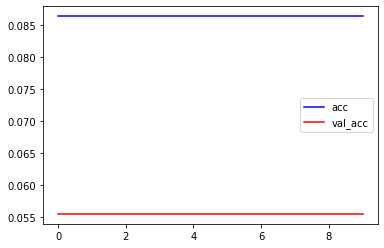

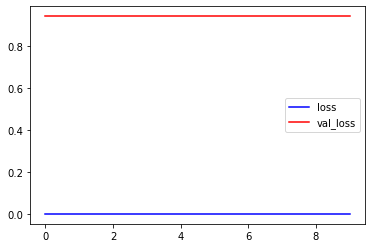

In [15]:
model = model.fit(train_data=(X_train,Y_train),
          epochs=10,
          #valid_data=(X_test,Y_test),
          lr=[0.01],
          decay=1e-08,
          batch_size=2,
          PlotView=10,
          Labels=Labels)

In [16]:
def SaveModel(obj,fileName) :
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)
    
def loadModel(fileName) :
    f = open(fileName, 'rb') 
    model = pickle.load(f)
    return model

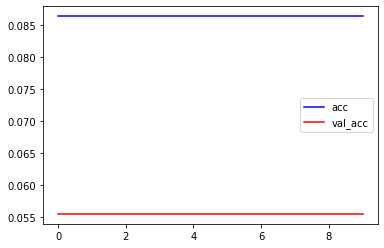

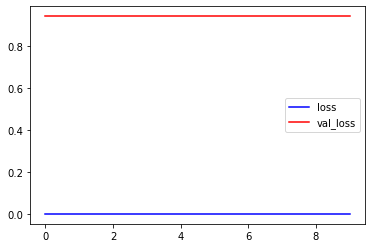

In [17]:
PlotAcc(model)
PlotError(model)

In [18]:
fileName = 'Model_Conv_1.0.h5'
model = loadModel(fileName)

In [19]:
c = 1000
plt.imshow(X_train[c])
plt.show()
Labels[model.pred_class(X_train[c])]

IndexError: index 1000 is out of bounds for axis 0 with size 360

In [ ]:
c = 0
for i in range(len(X_train)) :
    #print(model.pred_class(X_train[i]),Y_train[i])
    if model.pred_class(X_train[i]) == Y_train[i] :
        c += 1
print(c*100/len(X_train))